In [145]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

In [75]:
# form a datetime index with second through fifth columns in the data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

raw = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv',
                  parse_dates=[[1, 2, 3, 4]],
                  index_col=0,
                  date_parser=parse)
# remove the first column as it contains only the row number
raw = raw.iloc[:, 1:]
raw.index.name = 'time'

In [76]:
print('Raw data contain {} rows'.format(raw.shape[0]))
print()
print(raw.isnull().sum())
# handlering missing value
# remove the first 24 hours, and forward fill the rest missing PM2.5 values
raw = raw.iloc[24:].fillna(method='ffill')

Raw data contain 43824 rows

pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64


In [91]:
raw.head()
# 

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
time,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


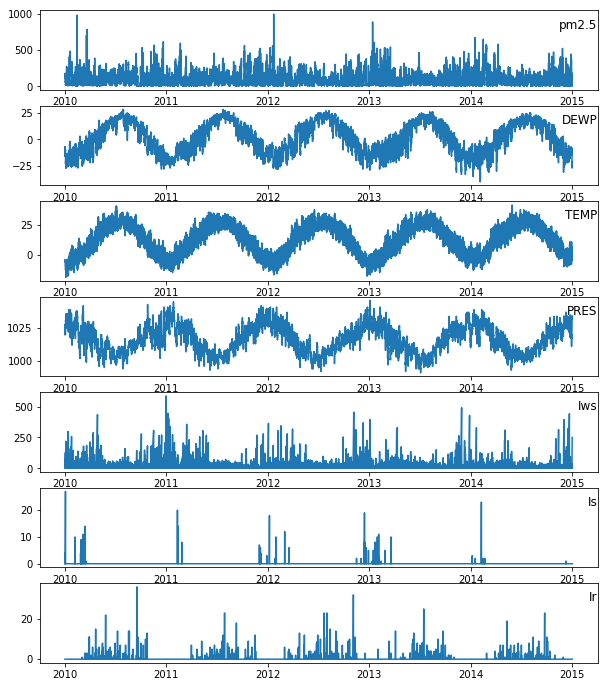

In [77]:
# plot the data
features = raw.columns[[0, 1, 2, 3, 5, 6, 7]]
plt.figure(figsize=(10, 12))
for i, feature in enumerate(features):
    plt.subplot(7, 1, i+1)
    plt.plot(raw[feature])
    plt.title(feature, y=0.7, loc='right')
plt.show()

In [115]:
# normalize features
num_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(raw[num_cols].values)
num_data = pd.DataFrame(scaled)
num_data.shape

(43800, 7)

In [111]:
# one-hot encode the wind direction feature
cat_data = pd.get_dummies(raw['cbwd'], prefix='cbwd').values
cat_data.shape

(43800, 4)

In [114]:
np.concatenate((num_data, cat_data), axis=1).shape

(43800, 11)

In [116]:
def load_data(data, seq_len):
    amount_of_features = data.shape[1]
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [118]:
window = 5

X_train, y_train, X_test, y_test = load_data(np.concatenate((cat_data, num_data), axis=1), window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (39415, 5, 11)
y_train (39415,)
X_test (4379, 5, 11)
y_test (4379,)


In [129]:
model = Sequential()
model.add(LSTM(input_shape=(5, 11), units=5, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 5, 5)              340       
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               268288    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 268,885
Trainable params: 268,885
Non-trainable params: 0
_________________________________________________________________


Train on 35473 samples, validate on 3942 samples
Epoch 1/50
 - 10s - loss: 0.0066 - val_loss: 0.0045
Epoch 2/50
 - 9s - loss: 0.0036 - val_loss: 0.0023
Epoch 3/50
 - 9s - loss: 0.0027 - val_loss: 0.0017
Epoch 4/50
 - 9s - loss: 0.0024 - val_loss: 0.0016
Epoch 5/50
 - 9s - loss: 0.0021 - val_loss: 0.0016
Epoch 6/50
 - 9s - loss: 0.0020 - val_loss: 0.0013
Epoch 7/50
 - 9s - loss: 0.0020 - val_loss: 0.0013
Epoch 8/50
 - 9s - loss: 0.0019 - val_loss: 0.0012
Epoch 9/50
 - 9s - loss: 0.0018 - val_loss: 0.0011
Epoch 10/50
 - 9s - loss: 0.0017 - val_loss: 0.0011
Epoch 11/50
 - 9s - loss: 0.0016 - val_loss: 9.5418e-04
Epoch 12/50
 - 9s - loss: 0.0016 - val_loss: 9.4111e-04
Epoch 13/50
 - 9s - loss: 0.0015 - val_loss: 9.3191e-04
Epoch 14/50
 - 9s - loss: 0.0014 - val_loss: 8.0140e-04
Epoch 15/50
 - 9s - loss: 0.0013 - val_loss: 8.1242e-04
Epoch 16/50
 - 9s - loss: 0.0013 - val_loss: 7.9037e-04
Epoch 17/50
 - 9s - loss: 0.0012 - val_loss: 7.7210e-04
Epoch 18/50
 - 9s - loss: 0.0011 - val_loss: 6.

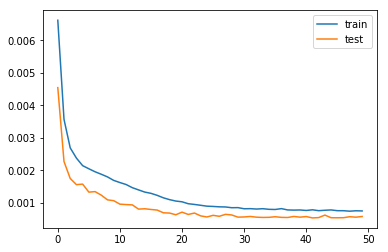

In [130]:
history = model.fit(X_train, y_train, batch_size=512, epochs=50, validation_split=0.1, verbose=2)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [138]:
X_test[:, 0, :].shape

(4379, 11)

In [146]:
# make a prediction
yhat = model.predict(X_test)
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((X_test[:, 0, 4:10], yhat), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((X_test[:, 0, 4:10], y_test), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(4379, 7)
Test RMSE: 19.576


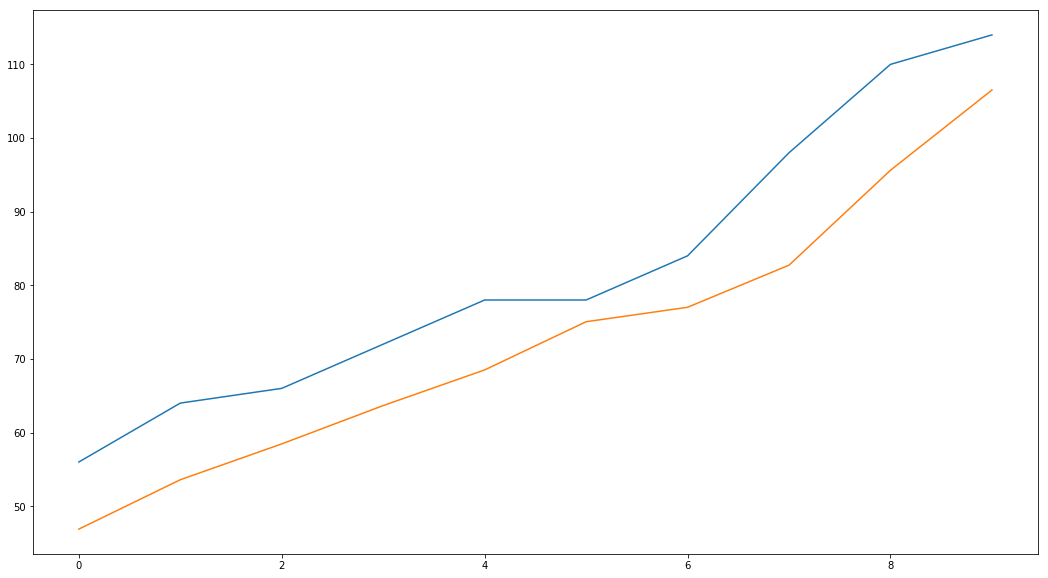

In [244]:
plt.figure(figsize=(18, 10))
plt.plot(inv_y[:10])
plt.plot(inv_yhat[:10])
plt.show()

In [238]:
def moving_test_window_preds(n_future_preds):

    ''' 
    n_future_preds - Represents the number of future predictions we want to make
    This coincides with the number of windows that we will move forward on the test data
    '''
    
    preds_moving = []  # predictions
    moving_test_window = X_test[np.newaxis, 0]  # with shape (1, 5, 11)
    
    for i in range(n_future_preds):
        pred = model.predict(moving_test_window)  # prediction for the next period, with shape (1, 1)
#         preds.append(preds_one_step[0,0])
        # concatenate the prediction to the first observation (drop last feature)
        # and reshape to 3D array with shape (1, 11, 1)
        new_ob = np.concatenate((X_test[i+1,4,:10].reshape(1,10), pred), axis=1)
        preds_moving.append(new_ob[:,4:].flatten())
#         preds.append(pred[:,:,4:].flatten())
#         print(preds_one_step[:,:,4:].shape)
        # concatenate the new observation to the end of the window
        moving_test_window = np.concatenate((new_ob, X_test[i+1,:4]), axis=0).reshape(1,5,11)
        
    preds_moving = scaler.inverse_transform(preds_moving)
    preds = preds_moving[:, -1]
    
    return preds

In [239]:
preds_moving = moving_test_window_preds(4000)

In [243]:
print(preds_moving)
print(inv_yhat)

[46.88860389 47.0240833  53.65893455 ...  0.64566658 -3.10084075
 -3.38596702]
[46.88859648 53.59185211 58.45975736 ... -3.7891874  -1.18755461
 -1.26937474]


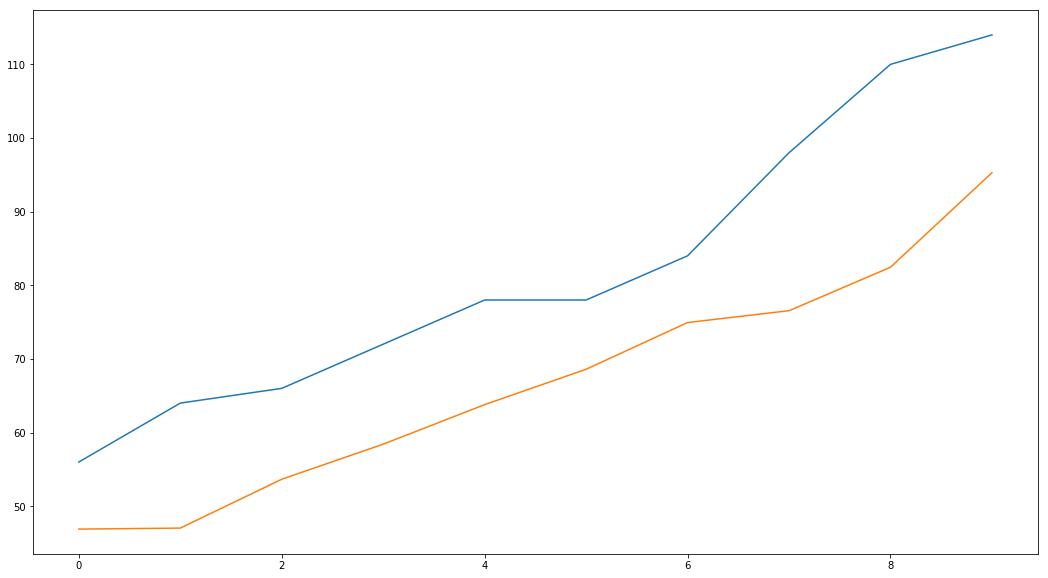

In [245]:
plt.figure(figsize=(18, 10))
plt.plot(inv_y[:10])
plt.plot(preds_moving[:10])
plt.show()